In [ ]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [ ]:
sp500.index = pd.to_datetime(sp500.index)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,0.0,0.0
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,0.0,0.0
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,0.0,0.0


<Axes: xlabel='Date'>

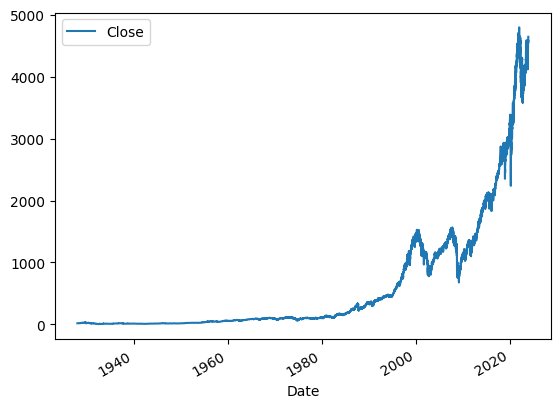

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.48717948717948717

<Axes: xlabel='Date'>

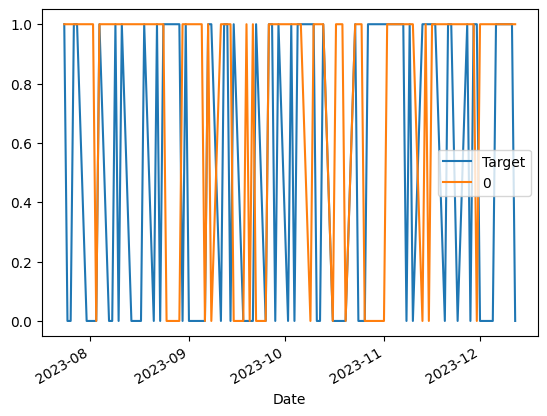

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

0    3457
1    2596
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5285053929121726

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.534115
0    0.465885
Name: Target, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,4585.589844,1,0.998043,0.0,0.995535,2.0,1.038998,33.0,1.075342,131.0,1.152479,527.0
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,4604.370117,1,1.003968,1.0,1.002686,2.0,1.046807,33.0,1.083273,131.0,1.161252,527.0
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,4622.439941,1,1.002044,2.0,1.006364,2.0,1.050697,33.0,1.087021,132.0,1.165591,528.0


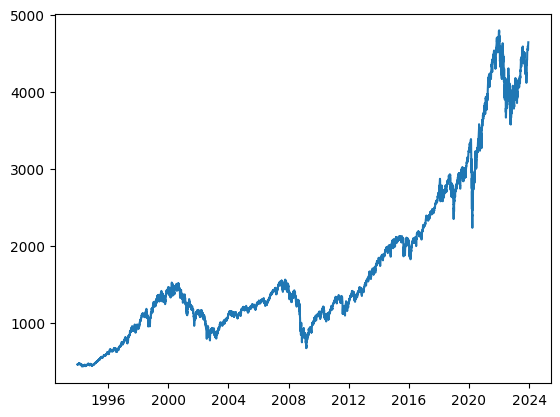

In [ ]:
plt.plot(sp500['Close'])

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

0.0    4223
1.0     830
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.572289156626506

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.543835
0    0.456165
Name: Target, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2023-12-06 00:00:00-05:00,1,1.0
2023-12-07 00:00:00-05:00,1,0.0
2023-12-08 00:00:00-05:00,1,0.0


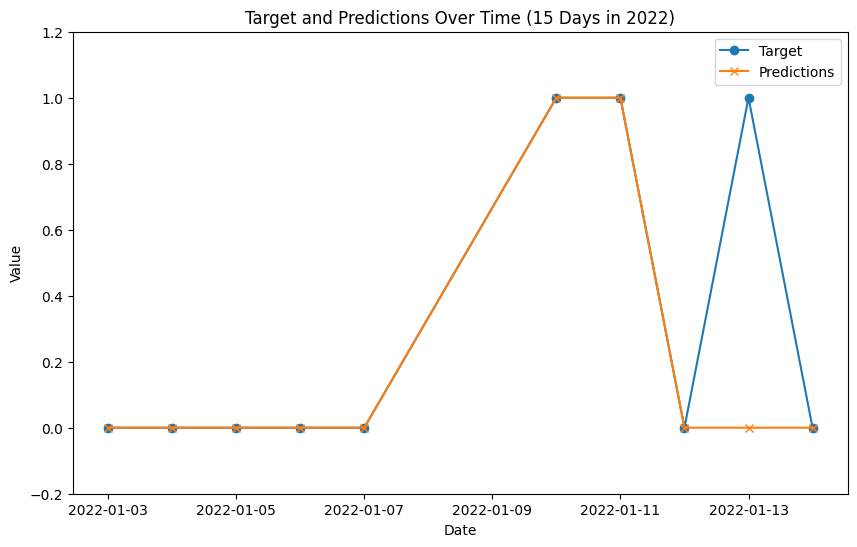

In [ ]:
def plot_predictions(predictions):
    # Filter data for the year 2022
    start_date = '2022-01-01'
    end_date = '2022-01-15'
    filtered_df = predictions[start_date:end_date]

    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.index, filtered_df['Target'], label='Target', marker='o')
    plt.plot(filtered_df.index, filtered_df['Predictions'], label='Predictions', marker='x')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target and Predictions Over Time (15 Days in 2022)')
    plt.legend()

    plt.ylim(-0.2, 1.2)

    plt.show()


plot_predictions(predictions)
